<a href="https://colab.research.google.com/github/dev-SR/Deep-Learning/blob/main/03-cnn-basic/cnn-basic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN Basic with pytorch

In [2]:
"""
cd .\03-cnn-basic\
jupyter nbconvert --to markdown cnn-basic.ipynb --output README.md
"""

import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

import torch
import torch.nn.functional as Fn
import torch.nn as nn

## Load Dataset from `torchvision`

- [Torchvision](https://pytorch.org/vision/stable/datasets.html)  provides many built-in datasets in the `torchvision.datasets` module, as well as utility classes for building your own datasets.



In [4]:
import torchvision
import torchvision.transforms as transforms
trainset = torchvision.datasets.CIFAR10(root='./data',
                                        train=True,
                                        download=True,
                                        transform=transforms.ToTensor())


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


In [9]:
trainloader = torch.utils.data.DataLoader(trainset,batch_size=4,shuffle=True)

In [13]:
dataiter = iter(trainloader)
images,labels  = next(dataiter)
print(images.shape) # [4, 3, 32, 32] -> [batch_size,channels,image_size(x,y)]

torch.Size([4, 3, 32, 32])


In [19]:
print(len(images)) # 4 images per batch
print(images[0].shape) # [3 channels, 32x32]
print(labels[0].item())

4
torch.Size([3, 32, 32])
3


## Visulize Data

In [20]:
img = images[0]
print(type(img))

<class 'torch.Tensor'>


In [25]:
npimg = img.numpy()
print(npimg.shape)  

(3, 32, 32)


In [26]:
npimg = np.transpose(npimg,(1,2,0))
print(npimg.shape) # [32x32,3 channels]


(32, 32, 3)


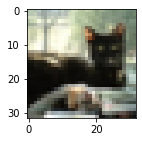

In [28]:
plt.figure(figsize=(2,2))
plt.imshow(npimg)
plt.show()

In [30]:
def imshow(img):
    npimg = img.numpy()
    npimg = np.transpose(npimg,(1,2,0))
    plt.imshow(npimg)
    plt.show()

In [29]:
classes= ( 'plane','car','bird' ,'cat', 'deer',' dog', 'frog' ,' horse' ,'ship','truck')

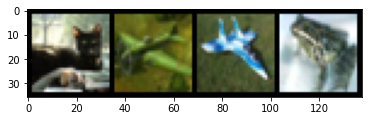

cat plane plane frog


In [92]:
imshow(torchvision.utils.make_grid(images))
print(" ".join(classes[labels[j]] for j in range(4)))

## Single Convolution Layer

<div align="center">
<img src="https://raw.githubusercontent.com/dev-SR/Deep-Learning/main/03-cnn-basic/img/ConvLayer.png" alt="ConvLayer.png" width="800px">
</div>

In [43]:
class FirstCNN(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        """ 
        in_channels: Number of channels in the input image
        out_channels: Number of channels produced by the convolution
        kernel_size: Size of the convolving kernel
        stride (int or tuple, optional): Stride of the convolution. Default: 1
        padding (int, tuple or str, optional): Padding added to all four sides of
            the input. Default: 0
        """
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=6,kernel_size=5) 
        #IN: (B,InC:3,32x32) -> OUT: (B,OutC:6,[32-(5-S1)x32-(5-1)]) -> OUT: (B,6C,28x28)
    
    def forward(self,X):
        X = self.conv1(X)
        return X

In [44]:
net = FirstCNN()
out  = net(images)
out.shape

torch.Size([4, 6, 28, 28])

In [45]:
for param in net.parameters():
    print(param.shape) #total number of parameters of (f*f*InC+1)*OutC.


torch.Size([6, 3, 5, 5])
torch.Size([6])


In [46]:
out1 = out[0,0,:,:].detach().numpy() #0th image of the batch,0th chanel, all x, all y
print(out1.shape)

(28, 28)


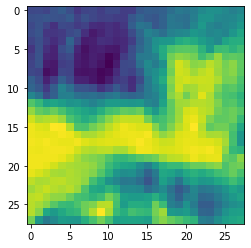

In [47]:
# ploting 
plt.imshow(out[0,0,:,:].detach().numpy())
plt.show()

## Deep Convolutional Network

In [48]:
class FirstCNN_v2(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3,8,3), # (B,InC:3,32x32) -> (B,OutC:8,30X30)
            nn.Conv2d(8,16,3) # (B,InC:8,30X30) -> (B,OutC:16,28x28)
        )
    
    def forward(self,X):
        X = self.model(X)
        return X

In [49]:
net = FirstCNN_v2()
out = net(images)
out.shape

torch.Size([4, 16, 28, 28])

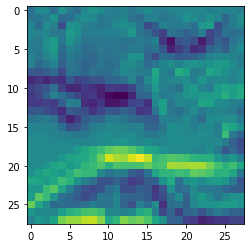

In [51]:
plt.imshow(out[0,0,:,:].detach().numpy())
plt.show()

In [52]:
class FirstCNN_v3(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3,6,5), # (B,InC:3,32x32) -> (B,OutC:6,28x28)
            nn.AvgPool2d(2,stride=2), # (B,6,28x28) ->(B,6,[28/sx28/s]) -> (B,6,14x14)
            nn.Conv2d(6,16,5), # (B,6,14x14) -> (B,16,10x10)
            nn.AvgPool2d(2,stride=2) # (B,16,10x10) ->(B,16,5x5)

        )
    
    def forward(self,X):
        X = self.model(X)
        return X

In [54]:
net = FirstCNN_v3()
out = net(images)
out.shape

torch.Size([4, 16, 5, 5])

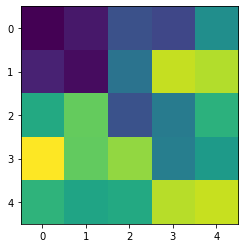

In [55]:
plt.imshow(out[0,0,:,:].detach().numpy())
plt.show()

## LeNet Architecture

<div align="center">
<img src="https://raw.githubusercontent.com/dev-SR/Deep-Learning/main/03-cnn-basic/img/ConvInOut.png" alt="ConvInOut.png" width="900px">
</div>

In [60]:
class LeNet(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.cnn_layer = nn.Sequential(
            nn.Conv2d(3,6,5),               # (B,3,32X32)   ->    (B,6,28X28)
            nn.Tanh(),
            nn.AvgPool2d(2,stride=2),       # (B,6,28X28)   ->    (B,6,14X14)
            nn.Conv2d(6,16,5),              # (B,6,14X14)   ->    (B,16,10X10)
            nn.Tanh(),
            nn.AvgPool2d(2,stride=2),       # (B,16,10X10)  ->    (B,16,5X5)
        )
        self.fc_layer = nn.Sequential(
            nn.Linear(400,120),             # (16X5X5) ~ (B,400) ->(B,120)
            nn.Tanh(),
            nn.Linear(120,84),              #            (B,120) ->(B,84)
            nn.Tanh(),
            nn.Linear(84,10)                #            (B,84) ->(B,10)
        )
    
    def forward(self,x):
        print(f"Input Shape:\n {x.shape}")
        x = self.cnn_layer(x)
        print(f"Conv Output Shape:\n {x.shape}")
        x = x.view(x.shape[0],-1)
        print(f"Flatten 16X5X5:\n {x.shape}")
        x = self.fc_layer(x)
        print(f"Finnal Output:\n {x.shape}")
        return x

In [106]:
net = LeNet()
out = net(images)
out.shape

Input Shape:
 torch.Size([4, 3, 32, 32])
Conv Output Shape:
 torch.Size([4, 16, 5, 5])
Flatten 16X5X5:
 torch.Size([4, 400])
Finnal Output:
 torch.Size([4, 10])


torch.Size([4, 10])

In [107]:
out.data

tensor([[ 0.0625, -0.1399,  0.0961, -0.0230, -0.0146, -0.0515, -0.0836,  0.1206,
          0.1640, -0.1140],
        [ 0.0669, -0.1321,  0.0714, -0.0048,  0.0176, -0.0743, -0.0849,  0.1291,
          0.1294, -0.0988],
        [ 0.0639, -0.1425,  0.0732, -0.0150, -0.0036, -0.0481, -0.0829,  0.1361,
          0.1606, -0.1030],
        [ 0.0565, -0.1518,  0.0409, -0.0276, -0.0195, -0.0477, -0.0655,  0.1325,
          0.1412, -0.0990]])

In [115]:
max_vals,pred_class = torch.max(out.data,dim=1)
pred_class

tensor([8, 8, 8, 8])

Get hold of individual layer:

In [62]:
out = net.cnn_layer[0](images) # Result of first convolution
out.shape

torch.Size([4, 6, 28, 28])

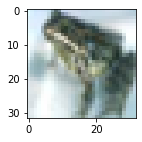

In [64]:
image_id =3
plt.figure(figsize=(2,2))
imshow(images[image_id])

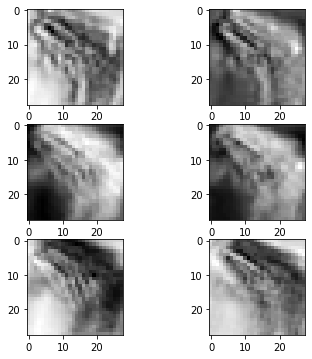

In [70]:
# ploting each channel of a resultant image after conv1
plt.figure(figsize=(6,6))
plt.subplot(321)
for i in range(6):
    ax = plt.subplot(3,2,i+1)
    ax.imshow(out[image_id,i,:,:].detach().numpy(),cmap="binary")
plt.show()

## Train LetNet

In [120]:
class LeNet(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.cnn_layer = nn.Sequential(
            nn.Conv2d(3,6,5),               # (B,3,32X32)   ->    (B,6,28X28)
            nn.Tanh(),
            nn.AvgPool2d(2,stride=2),       # (B,6,28X28)   ->    (B,6,14X14)
            nn.Conv2d(6,16,5),              # (B,6,14X14)   ->    (B,16,10X10)
            nn.Tanh(),
            nn.AvgPool2d(2,stride=2),       # (B,16,10X10)  ->    (B,16,5X5)
        )
        self.fc_layer = nn.Sequential(
            nn.Linear(400,120),             # (16X5X5) ~ (B,400) ->(B,120)
            nn.Tanh(),
            nn.Linear(120,84),              #            (B,120) ->(B,84)
            nn.Tanh(),
            nn.Linear(84,10)                #            (B,84) ->(B,10)
        )
    
    def forward(self,x):
        x = self.cnn_layer(x)
        x = x.view(x.shape[0],-1)
        x = self.fc_layer(x)
        return x

In [72]:
import shutil
shutil.rmtree('/content/data') #deletes a directory and all its contents.

In [155]:
batch_size = 128
trainset = torchvision.datasets.CIFAR10(root='./data',train=True,download=True,transform=transforms.ToTensor())
trainloader = torch.utils.data.DataLoader(trainset,batch_size=batch_size,shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data',train=False,download=True,transform=transforms.ToTensor())
testloader = torch.utils.data.DataLoader(testset,batch_size=batch_size,shuffle=False)



Files already downloaded and verified
Files already downloaded and verified


In [176]:
def evaluation(dataloader):
    total,correct = 0,0
    for data in dataloader:
        inputs,labels = data
        outputs = net(inputs)
        _,pred = torch.max(outputs.data,dim=1)
        total += labels.size(0)
        correct += (pred==labels).sum().item()
    
    return 100*correct/total

In [174]:
from tqdm.notebook import tqdm
import torch.optim as optim
loss_fn = nn.CrossEntropyLoss()
opt = optim.Adam(net.parameters())
net = LeNet()

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 0/16, Test acc: 9.90, Train acc: 9.96
Epoch: 1/16, Test acc: 9.90, Train acc: 9.96
Epoch: 2/16, Test acc: 9.90, Train acc: 9.96
Epoch: 3/16, Test acc: 9.90, Train acc: 9.96
Epoch: 4/16, Test acc: 9.90, Train acc: 9.96
Epoch: 5/16, Test acc: 9.90, Train acc: 9.96
Epoch: 6/16, Test acc: 9.90, Train acc: 9.96
Epoch: 7/16, Test acc: 9.90, Train acc: 9.96
Epoch: 8/16, Test acc: 9.90, Train acc: 9.96
Epoch: 9/16, Test acc: 9.90, Train acc: 9.96
Epoch: 10/16, Test acc: 9.90, Train acc: 9.96
Epoch: 11/16, Test acc: 9.90, Train acc: 9.96
Epoch: 12/16, Test acc: 9.90, Train acc: 9.96
Epoch: 13/16, Test acc: 9.90, Train acc: 9.96
Epoch: 14/16, Test acc: 9.90, Train acc: 9.96
Epoch: 15/16, Test acc: 9.90, Train acc: 9.96


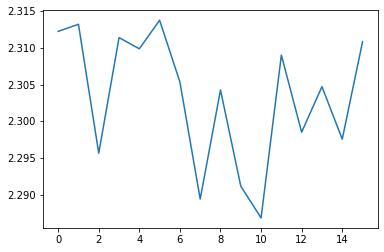

CPU times: user 8min 55s, sys: 1.42 s, total: 8min 57s
Wall time: 8min 57s


In [177]:
%%time
max_epochs = 16
loss_arr = []
loss_epoch_arr = []

for epoch in tqdm(range(max_epochs)):
    for i,data in enumerate(trainloader):
        inputs,labels = data
        opt.zero_grad()
        
        outputs = net(inputs)

        loss = loss_fn(outputs,labels)
        loss_arr.append(loss.item())
       
        loss.backward()
        opt.step()

    loss_epoch_arr.append(loss.item())    
    print("Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f" % (epoch,max_epochs,evaluation(testloader),evaluation(trainloader)))

plt.plot(loss_epoch_arr)
plt.show()


## Move to GPU

In [178]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [179]:
net = LeNet().to(device)

In [180]:
%%time
max_epochs = 16
for epoch in tqdm(range(max_epochs)):
    for i,data in enumerate(trainloader):
        inputs,labels = data
        # send data to gpu 
        inputs,labels = inputs.to(device),labels.to(device)        
        opt.zero_grad()
        outputs = net(inputs)

        loss = loss_fn(outputs,labels)
        loss.backward()
        opt.step()
    print("Epoch: %d/%d" % (epoch,max_epochs))


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 0/16
Epoch: 1/16
Epoch: 2/16
Epoch: 3/16
Epoch: 4/16
Epoch: 5/16
Epoch: 6/16
Epoch: 7/16
Epoch: 8/16
Epoch: 9/16
Epoch: 10/16
Epoch: 11/16
Epoch: 12/16
Epoch: 13/16
Epoch: 14/16
Epoch: 15/16
CPU times: user 2min 55s, sys: 935 ms, total: 2min 56s
Wall time: 2min 56s


In [181]:
def evaluation(dataloader):
    total,correct = 0,0
    for data in dataloader:
        inputs,labels = data
        # send data to gpu 
        inputs,labels = inputs.to(device),labels.to(device)
        outputs = net(inputs)
        _,pred = torch.max(outputs.data,dim=1)
        total += labels.size(0)
        correct += (pred==labels).sum().item()
    
    return 100*correct/total

In [182]:
print("est acc: %0.2f, Train acc: %0.2f" % (evaluation(testloader),evaluation(trainloader)))


est acc: 9.99, Train acc: 10.00
